## Homework 1: camera calibration

**Due date:** February 16, 2022

The goal of the assignment is to implement the linear calibration method described in Section 1.3.1 of this [book chapter](https://www.di.ens.fr/%7Eponce/introvis/sbook.pdf).

![calibration-image](img/calibration.jpg)

**Detailed instructions:** The `pts2d` array contains in its columns the (u,v) positions of the image data points (with, by convention, the u and v coordinates with origin at the bottom left of the image, u going right and v going up), while the `pts3d` array contains in its columns the (x,y,z) coordinate vectors of the corresponding 3D points in a right-handed coordinate system. The origin of the world coordinate system is supposed to be in front of the camera, with negative z value.

You should write functions that:
* Compute the 3x4 projection matrix  M estimated from these data using the linear least-squares method of Sec. 1.3.1.
* Compute the corresponding matrix K of intrinsic parameters using the method from M using the method described in the same section.
* Draw together the input image points and the projection of the 3D data points obtained using M to generate a figure like Fig. 1.18, and estimate the root-mean-sqared reprojection error.

You should also write short explanations describing your work and reporting your results.

#### Load and plot data

World: (491, 3)


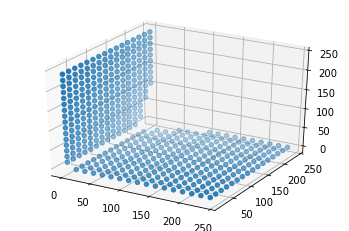

Image: (491, 2)


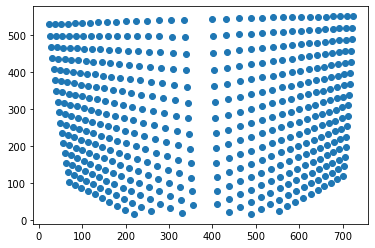

In [1]:
# Name: Stephen Spivack
# NetID: ss7726
# email:ss7726@nyu.edu

import math
import numpy as np
import matplotlib.pyplot as plt

pts3d = np.loadtxt("pts3d.txt")
print('World:',pts3d.shape)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pts3d[:,0],pts3d[:,1],pts3d[:,2])
plt.show()

pts2d = np.loadtxt("pts2d.txt")
print('Image:',pts2d.shape)
plt.scatter(pts2d[:,0],pts2d[:,1])
plt.show()

#### Compute the 3x4 projection matrix M estimated from these data using the linear least-squares method of Sec. 1.3.1.

In [2]:
def estimate_projection_matrix(pts_3d,pts_2d):
    
    # Pm = 0 -> solve for m!
    # Init number of points, empty matrix P, indexer for matrix P
    n = len(pts_3d)
    P = np.empty([2*n,12])*np.NaN
    ind = np.linspace(0,n*2-2,n,dtype=int)
    
    # Iteratively construct matrix P two rows at a time
    # P = [2n x 12] array that takes the following form:
    # [ Xi Yi Zi 1  0  0  0  0 -uiXi -uiYi -uiZi -ui ]
    # [ 0  0  0  0  Xi Yi Zi 1 -viXi -viYi -viZi -vi ]
    for i in range(n):
        x,y,z = pts_3d[i,:]
        u,v = pts_2d[i,:]
        temp = np.array([[x,y,z,1,0,0,0,0,-u*x,-u*y,-u*z,-u],
                         [0,0,0,0,x,y,z,1,-v*x,-v*y,-v*z,-v]])
        P[ind[i]:ind[i]+2] = temp
    
    # Compute PtP and select eigenvector corresponding to smallest 
    # eigenvalue; reshape into the 3x4 projection matrix M.
    P_ = np.matmul(P.T,P)
    U,S,Vt = np.linalg.svd(P_)
    m = Vt.transpose()[:,11]
    M = m.reshape(3,4)
    scaleFac = 1/M[2,3]
    M = scaleFac*M
    return M

# Run function on our data to compute M:
M = estimate_projection_matrix(pts3d,pts2d)
print('3x4 Projection matrix M:')
print(M)

3x4 Projection matrix M:
[[ 3.16571712e+00  3.94842772e-01 -1.41645622e+00  3.65325181e+02]
 [ 1.28677766e+00 -2.90467263e+00  1.17855035e+00  5.95068478e+02]
 [ 2.27417778e-03  7.94670776e-04  2.34089530e-03  1.00000000e+00]]


Here, I define the function **estimate_projection_matrix** which takes as its input numpy arrays
containing 3D world points and their 2D image points. First, the function computes the number
of points, initializes an empty matrix for M, and creates a number line used to index M. Next,
the function iteratively constructs M two rows at a time so that we end with a [2n x 12] array.
Last, the function matrix multiplies P transpose and P, performs a singular value decomposition, 
and selects the eigenvector corresponding to the smallest eigenvalue; this is reshaped into the 
[3 x 4] projection matrix M and normalized with respect to M(3,4).

#### Compute the corresponding matrix K of intrinsic parameters using the method from M using the method described in the same section.

Intrinsic matrix K:
[[-3.25922707 -0.         -1.24958106]
 [-0.         -3.23592362 -1.00533533]
 [-0.         -0.         -0.00335904]]


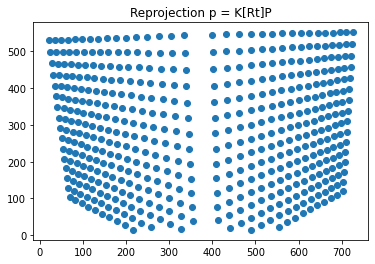

In [3]:
def decompose_projection_matrix(projection_matrix):
    
    # Input: 3x4 projection matrix estimated from pts3d and pts2d
    # Output: 3x3 intrinsic matrix K, 3x3 rotation matrix R, 3x1 translation vector t 
    
    # We know: p = MP
    # We can rewrite as: p = K[Rt]P
    
    # We can rewrite matrix M = rho*[A b]
    A,b = M[:,:3],M[:,3].reshape(-1,1)
    a1,a2,a3 = A[0,:],A[1,:],A[2,:]
    rho = (-1/np.linalg.norm(a3))

    # Compute R:
    r3 = rho*a3
    r1 = 1/(np.linalg.norm(np.cross(a2,a3))) * np.cross(a2,a3)
    r2 = np.cross(r3,r1)
    R = np.concatenate((r1.reshape(1,-1),r2.reshape(1,-1),r3.reshape(1,-1)))

    # Compute parameters of K and construct matrix:
    alpha = (rho**2)*np.linalg.norm(np.cross(a1,a3))*np.sin(math.pi/2)
    beta = (rho**2)*np.linalg.norm(np.cross(a2,a3))*np.sin(math.pi/2)
    x0 = (rho**2)*np.dot(a1,a3)
    y0 = (rho**2)*np.dot(a2,a3)
    K = (np.array([[alpha,0,x0],[0,beta,y0],[0,0,1]]))/rho
    print('Intrinsic matrix K:')
    print(K)

    # Compute t:
    t = np.matmul(np.linalg.inv(K),b)
    
    # Return outputs:
    return K,R,t
    
# Run function on projection matrix M:
K,R,t = decompose_projection_matrix(M)

# Compute p = K[Rt]P:
extrinsic_matrix = np.concatenate((R,t),axis=1)
temp = np.matmul(extrinsic_matrix,np.concatenate((pts3d,np.ones([len(pts3d),1])),axis=1).transpose())
p = np.matmul(K,temp)
p = p/p[2,:] 

# Plot the data:
plt.plot(p[0,:],p[1,:],'o')
plt.title('Reprojection p = K[Rt]P')
plt.show()

Here, I define the function **decompose_projection_matrix** which takes as its input a 3x4 projection matrix and outputs its decomposition into K (3x3 instrinsic parameters), R (3x3 rotation) and t (3x1 translation). First, the function rewrites the projection matrix M as rho*[A b] and separates the rows of A as a1, a2 and a3; it also separates b as a column vector. Next, the function computes rho and each row of the 3x3 rotation matrix R. Next, using rho and the rows of A the function computes the camera intrinsic parameters and constructs the 3x3 intrinsic matrix K. Last, the function computes the 3x1 translation vector t and outputs K, R and t. To test whether the intrinsic matrix was correctly computed, the function recomputes p = K[Rt]P and plots the corresponding image.

#### Draw together the input image points and the projection of the 3D data points obtained using M to generate a figure like Fig. 1.18, and estimate the root-mean-squared reprojection error.

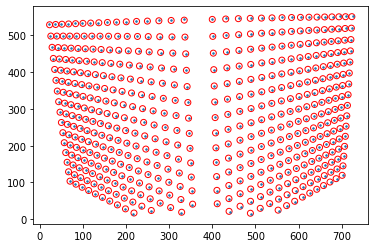

RMS projection error:
0.9573541639376526


In [4]:
def estimate_reprojection_error(projection_matrix,pts_3d,pts_2d):
    
    # number of points:
    n = len(pts_3d)
    
    # 3d points in homogenous coordinates:
    temp = np.concatenate((pts_3d,np.ones([n,1])),axis=1).transpose()
   
    # compute transpose of matrix multiplication of M and temp:
    reprojection = np.matmul(projection_matrix,temp).transpose()
    
    # normalized with resepect to z-coordinates:
    reprojection = reprojection/reprojection[:,2].reshape(-1,1)
    
    # superimposed plot of reprojection and actual points:
    plt.plot(reprojection[:,0],reprojection[:,1],'.',markersize=3)
    plt.scatter(pts_2d[:,0],pts_2d[:,1],color='none',edgecolor='r')
    plt.show()
    
    # compute rmse and return as output:
    error = np.sqrt(sum((reprojection[:,:2].flatten() - pts_2d.flatten())**2)/n)
    return error
    
# Run function on our data to compute M:
error = estimate_reprojection_error(M,pts3d,pts2d)
print('RMS projection error:')
print(error)

Here, I define the function **estimate_reprojection_error** which takes as its input numpy arrays containing 
the projection matrix, 3D world points and their 2D image points. First, the function computes the number 
of input points and represents the 3D points as homogenous coordinates. Next, it computes the reprojection
by matrix multiplying the homogenous coordinates by the 3x4 projection matrix; taking the transpose; then
normalizing with respect to the z-coordinates. Last, it plots the reprojection and the actual 2D points in
the same figure and computes the RMSE and returns it as the output. For these data, the RMSE is about 0.957.